# Table of Contents
 <p><div class="lev1"><a href="#目的"><span class="toc-item-num">1&nbsp;&nbsp;</span>目的</a></div><div class="lev1"><a href="#データのロード"><span class="toc-item-num">2&nbsp;&nbsp;</span>データのロード</a></div><div class="lev2"><a href="#モデルファイルのロード"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>モデルファイルのロード</a></div><div class="lev1"><a href="#エンコード、デコード"><span class="toc-item-num">3&nbsp;&nbsp;</span>エンコード、デコード</a></div><div class="lev2"><a href="#エンコード"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>エンコード</a></div><div class="lev2"><a href="#デコード"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>デコード</a></div><div class="lev1"><a href="#クラス化する"><span class="toc-item-num">4&nbsp;&nbsp;</span>クラス化する</a></div>

# 目的
* 学習済みのAEモデルを使って画像の再構成をする

In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pandas as pd
import six
import math

from PIL import Image
from StringIO import StringIO
import matplotlib.pyplot as plt

import chainer
from chainer import cuda, Function, gradient_check, Variable, optimizers, serializers, utils
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.functions.loss.vae import gaussian_kl_divergence

import tables

from model_VAE import VAE

# データのロード

In [2]:
## 刺激画像
fileStimuli = "../DataSet/Stimuli.mat"
dataStimuli = tables.open_file(fileStimuli)
imgStimuli = dataStimuli.get_node('/st')[:]
imgStimuliVd = dataStimuli.get_node('/sv')[:]
print 'DataShape [Stimuli] : {}'.format(imgStimuli.shape)
print 'DataShape [Stimuli for varidation] : {}'.format(imgStimuliVd.shape)

DataShape [Stimuli] : (108000, 3, 128, 128)
DataShape [Stimuli for varidation] : (8100, 3, 128, 128)


In [3]:
## 15fpsで映像を見せているので、とりあえず15枚ずつ間引く
train_x= imgStimuli[np.arange(0, imgStimuli.shape[0], 15)]
train_x = train_x.astype(np.float32)
### テストデータ
test_x= imgStimuliVd[np.arange(0, imgStimuliVd.shape[0], 15)]
test_x = test_x.astype(np.float32)

## データの正規化
train_x = train_x / 255
test_x = test_x / 255
print 'train_x.shape={}'.format(train_x.shape)
print 'test_x.shape={}'.format(test_x.shape)

N_train = train_x.shape[0]
N_test = test_x.shape[0]
print('N_train={}, N_test={}'.format(N_train, N_test))


train_x.shape=(7200, 3, 128, 128)
test_x.shape=(540, 3, 128, 128)
N_train=7200, N_test=540


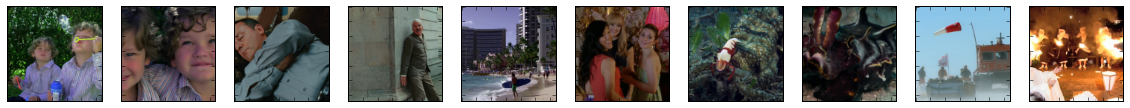

In [4]:
def draw_img_rgb(data, size=128):
    n = data.shape[0]
    plt.figure(figsize=(n*2, 2))
    data /= data.max()
    cnt = 1
    for idx in np.arange(n):
        plt.subplot(1, n, cnt)
        tmp = data[idx,:,:,:].transpose(2,1,0)
        plt.imshow(tmp)
        plt.tick_params(labelbottom="off")
        plt.tick_params(labelleft="off")
        cnt+=1
    plt.show()
#draw_img_rgb( train_x[np.random.permutation( test_x.shape[0] )[:7]] )
idx = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
draw_img_rgb( test_x[idx] )

## モデルファイルのロード

In [5]:
n_latent = 1000
input_size = 128
input_ch = 3
output_ch = 512

# 学習済みモデルファイル
model_file = 'out/out_models_vae_stim01/model_VAE_00500.h5'
model = VAE(n_latent=n_latent, input_size=input_size, input_ch=input_ch, output_ch=output_ch)
serializers.load_hdf5(model_file, model)

# エンコード、デコード

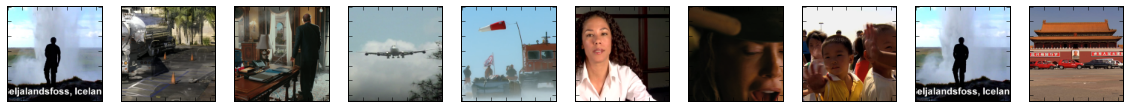

In [13]:
test_ind = np.random.permutation(N_test)[:10]
test = chainer.Variable(np.asarray(test_x[test_ind]), volatile='on')

draw_img_rgb(test.data)

In [20]:
test.data.shape

(10, 3, 128, 128)

## エンコード

In [17]:
mu, sig = model.encode(test)
print mu.data.shape

(10, 1000)


## デコード

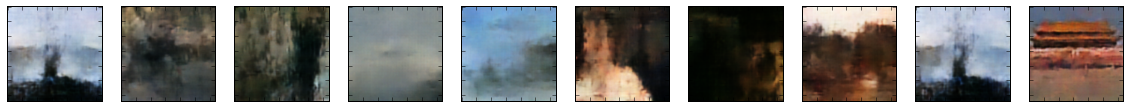

In [18]:
#y = model(test)
y = model.decode(mu)
draw_img_rgb(y.data)

# クラス化する

In [24]:
class EncodeDecode():
    def __init__(self, model_file, n_latent=1000, input_size=128, input_ch=3, output_ch=512):
        self.n_latent = n_latent
        self.input_size = input_size
        self.input_ch = input_ch
        self.output_ch = output_ch
        self.model_file = model_file
        self.model = VAE(n_latent=n_latent, input_size=input_size, input_ch=input_ch, output_ch=output_ch)
        serializers.load_hdf5(self.model_file, self.model)
    
    def getLatentVector(self, images):
        '''
        中間表現ベクトルを取得する
        arguments:
            images : 画像データ. 
                サイズ : [N, ch, width, height]
                    N=画像枚数, ch=チャネル(カラーの場合3)
                    0~1に正規化されたデータ
                型 : chainer.Variable()
        return:
            latent_vector : n_latent次元のベクトル
        '''
        mu, sig = model.encode(images)
        self.mu = mu
        self.sig = sig
        return mu
    
    def getReconstructImage(self, z):
        y = model.decode(z)
        return y

In [25]:
ae = EncodeDecode(model_file='out/out_models_vae_stim01/model_VAE_00500.h5')

In [26]:
z = ae.getLatentVector(test)

In [27]:
y = ae.getReconstructImage(z)

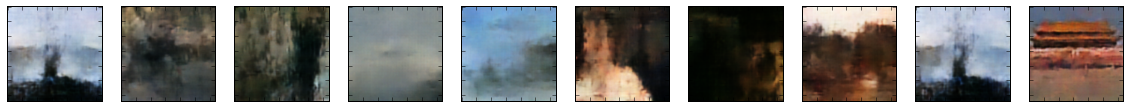

In [28]:
draw_img_rgb(y.data)